In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('icefire')

import warnings
warnings.filterwarnings('ignore')

### Read data

In [2]:
df = pd.read_csv('../data/train.csv', na_values="NAN")
df.shape

(1460, 81)

In [3]:
# check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# There are quite a few features where NA label is translated as missing. This must be fixed to preserve the context.

In [5]:
## Following are the list of features, where the missing value have a meaning of either not-applicable or not-avaliable. Here I am replace with 'None' for encoding later.
null_has_meaning = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for f in null_has_meaning:
    df[f].fillna('None', inplace = True)

In [6]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


In [7]:
## Observe features with missing values
cols_with_na = [f for f in df.columns if sum(~df[f].isna()) != len(df)]
df[cols_with_na].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrType   1452 non-null   object 
 2   MasVnrArea   1452 non-null   float64
 3   Electrical   1459 non-null   object 
 4   GarageYrBlt  1379 non-null   float64
dtypes: float64(3), object(2)
memory usage: 57.2+ KB


In [8]:
# Drop LotFrontage because of nearly 18% missing values
df.drop(columns = ['LotFrontage'], inplace = True)

In [9]:
for f in [c for c in cols_with_na if c in df.columns]:
    if df[f].dtypes == object:
        df[f].fillna(df[f].dropna().mode().values[0], inplace = True)
    else:
        df[f].fillna(df[f].dropna().median(), inplace = True)

In [10]:
cols_with_na = [f for f in df.columns if sum(~df[f].isna()) != len(df)]
cols_with_na

[]

### Organize features

In [11]:
# drop Id column because it is not useful
df.drop(columns = ['Id'], inplace = True)

# target
target = 'SalePrice'            # target is a numerical feature

# numerical features
num_features = [f for f in df.columns if (df[f].dtype in ['int64', float]) & (f != target)]

# catagorical features
cat_features = [f for f in df.columns if (df[f].dtype == object) & (f != target)]

print(f'Total columns in the dataset: {df.shape[1]}')
print(f'Total # of numerical features: {len(num_features)}')
print(f'Total # of numerical features: {len(cat_features)}')

Total columns in the dataset: 79
Total # of numerical features: 35
Total # of numerical features: 43


In [12]:
print('NUMERICAL FEATURES')
print(', '.join(num_features))
print()
print('CATEGORICAL FEATURES')
print(', '.join(cat_features))

NUMERICAL FEATURES
MSSubClass, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold

CATEGORICAL FEATURES
MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition


#### Investigate traget (Sale price)

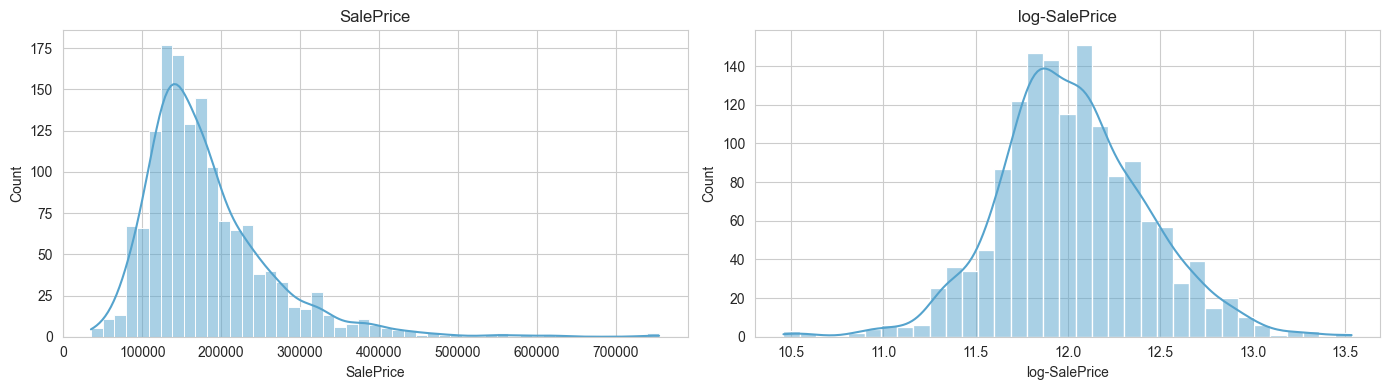

In [13]:
### Target
fig, axes = plt.subplots(1, 2, figsize = (14, 4))
sns.histplot(data = df, x = target, kde = True, ax = axes[0])
axes[0].set(title = target)

# log-transformation
df[f'log-{target}'] = df[target].apply(np.log)
sns.histplot(data = df, x = f'log-{target}', kde = True, ax = axes[1])
axes[1].set(title = f'log-{target}')

plt.tight_layout()
plt.show()


Original sale price is a right-skewed distribution, where only few houses with > 500,000. With log-transformation, the distribution is near-normal.

#### Investigate numerical features

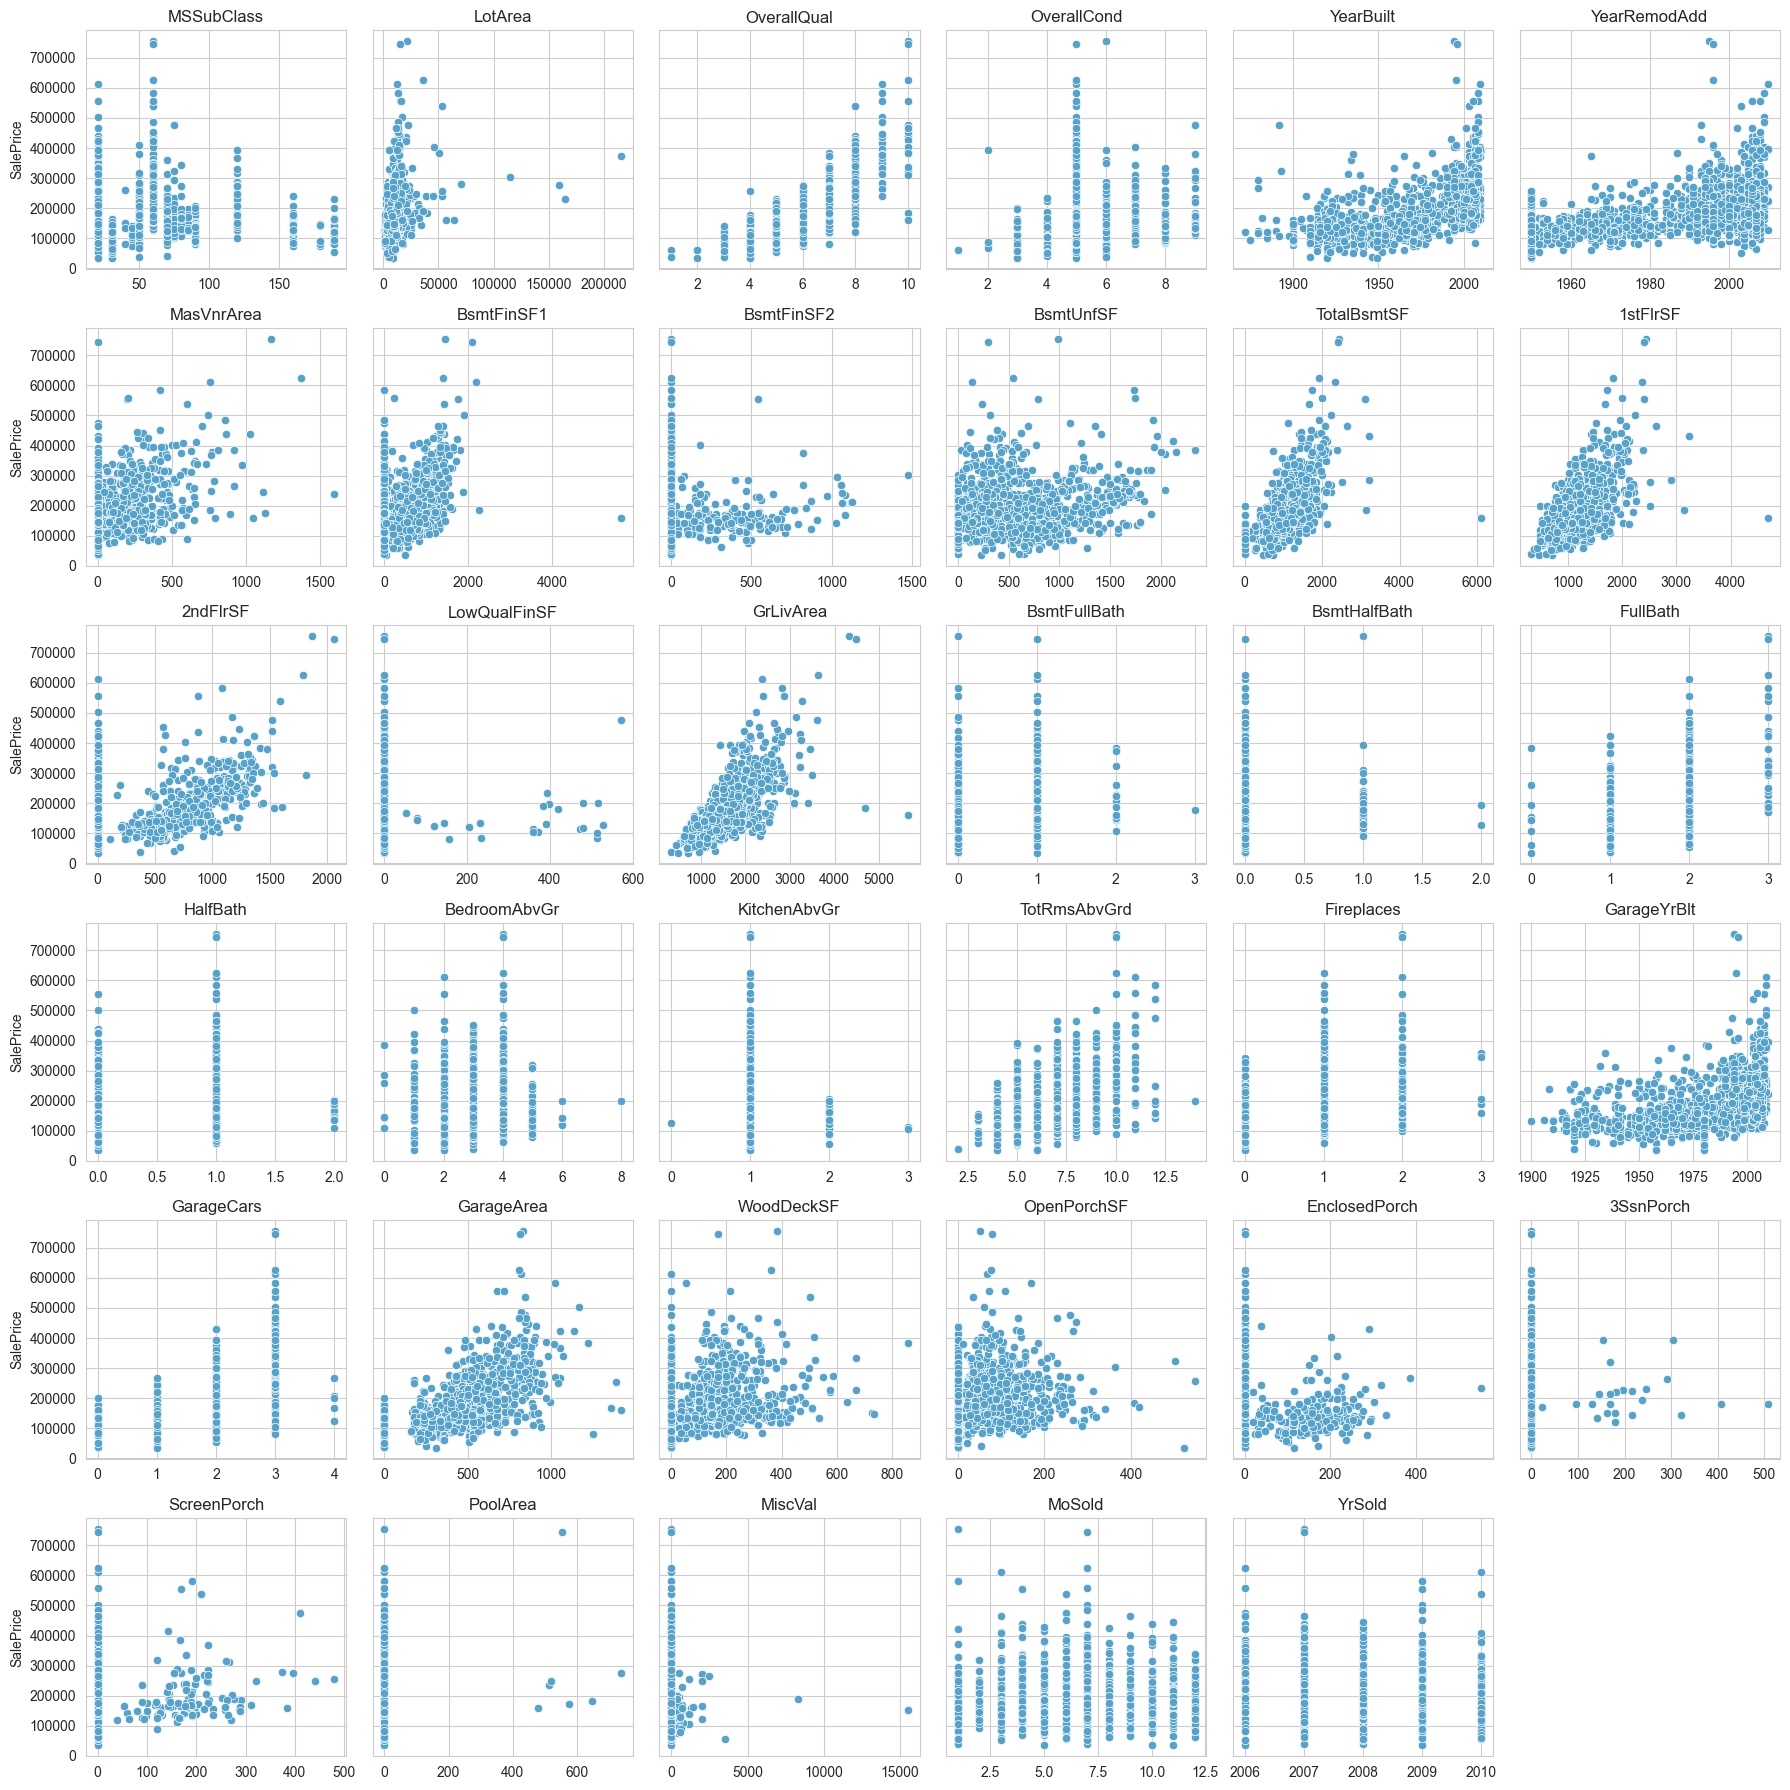

In [22]:
### Relationship between numerical features and target
fig, axes = plt.subplots(6,6, figsize = (18, 18), sharey = True)
for idx, ax in enumerate(axes.flatten()):
    if idx < len(num_features):
        sns.scatterplot(data = df, x = num_features[idx], y = target, ax = ax)
        ax.set(title = num_features[idx], xlabel = None)
    else:
        ax.remove()
plt.tight_layout()
plt.show()

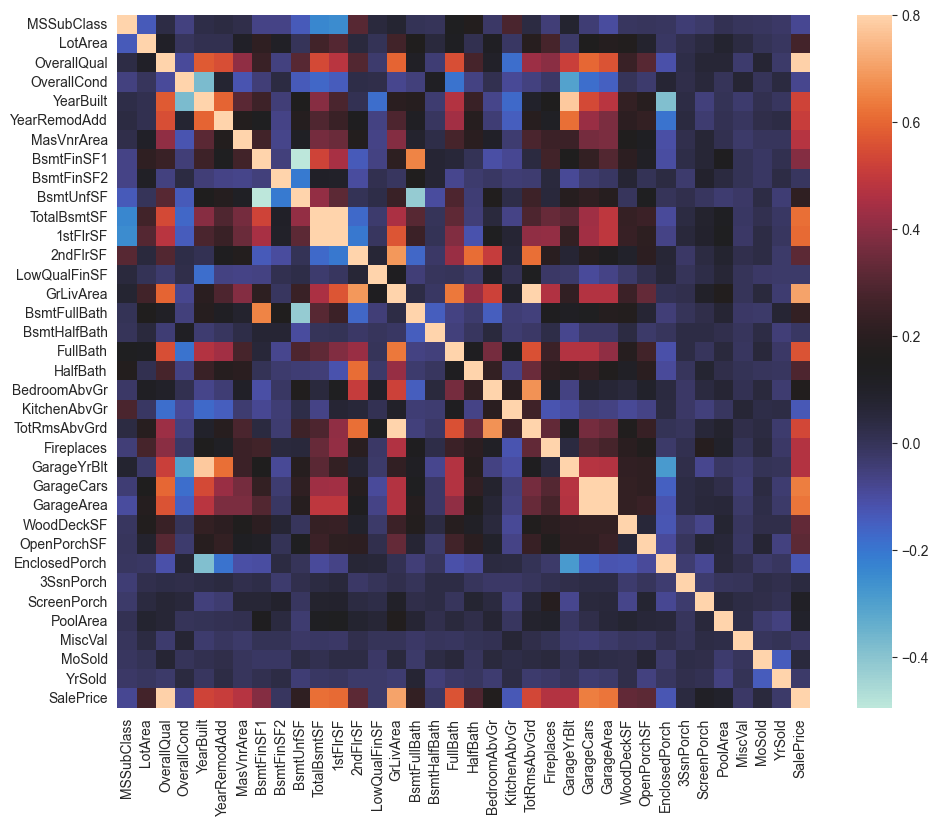

In [37]:
## correlation
#correlation matrix
corrmat = df[num_features + [target]].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap= 'icefire')
plt.show()

Correlation matix between SalePrice and top 12 numerical features


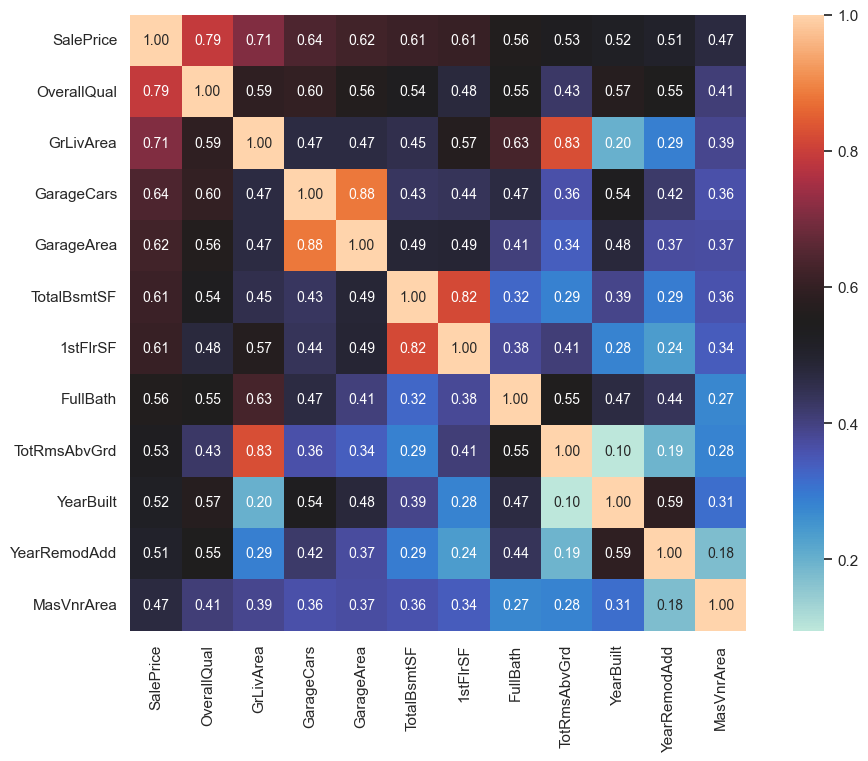

In [45]:
## correlation between
k = 12 #number of variables for heatmap
print(f'Correlation matix between {target} and top {k} numerical features')
cols = corrmat.nlargest(k, target)[target].index
cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize = (12, 8))
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values,
                 cmap = 'icefire')
plt.show()

Sale price of a house is strongly correlated with overall quality, living area, garage area (which itself is correlated with # of cars can fit in it), basement area, first floor area, and # of full baths. It is also correlated with year the property was built and the year remodeled.

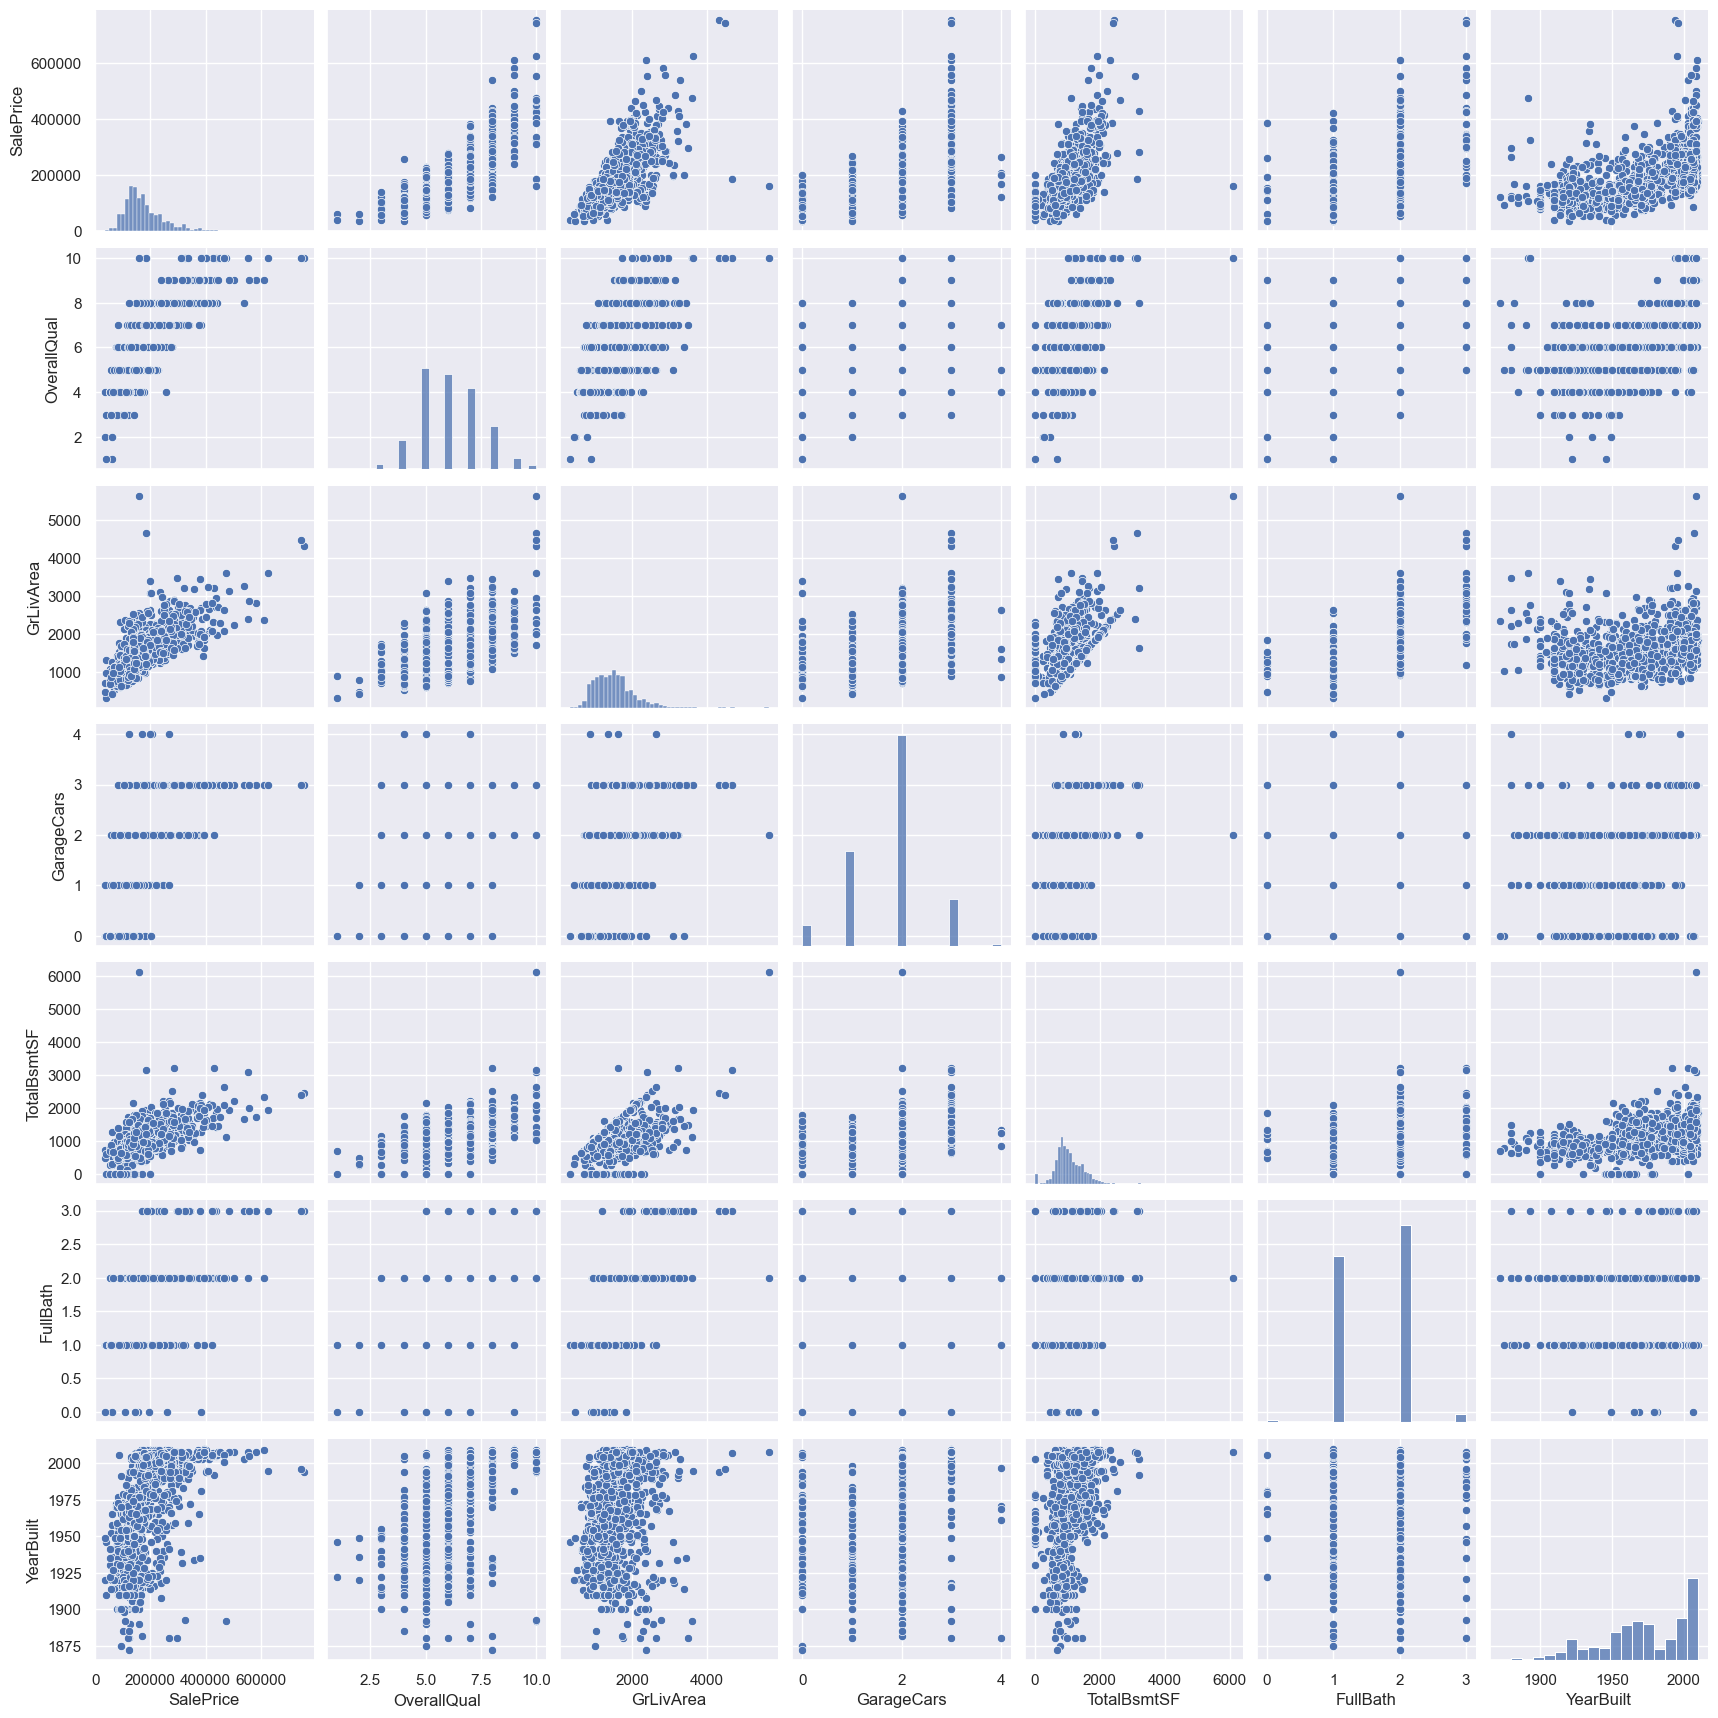

In [47]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show()

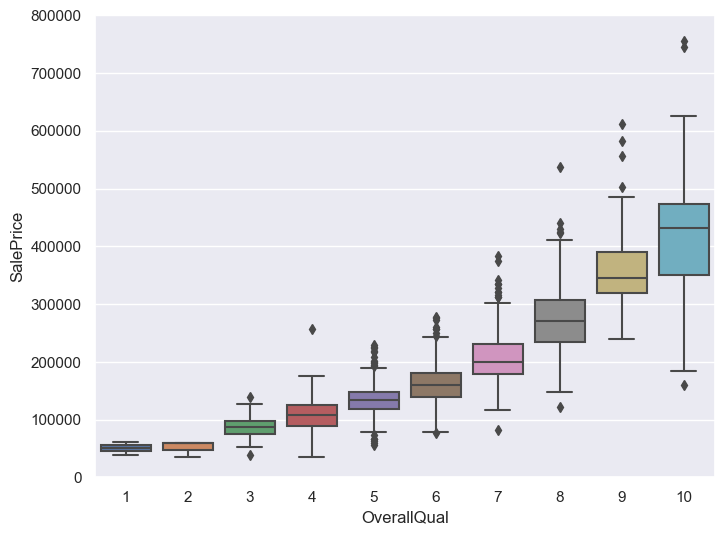

In [48]:
#box plot overallqual/saleprice
var = 'OverallQual'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=df)
fig.axis(ymin=0, ymax=800000)
plt.show()

Variance in the price increases with increase in overall quality of the property

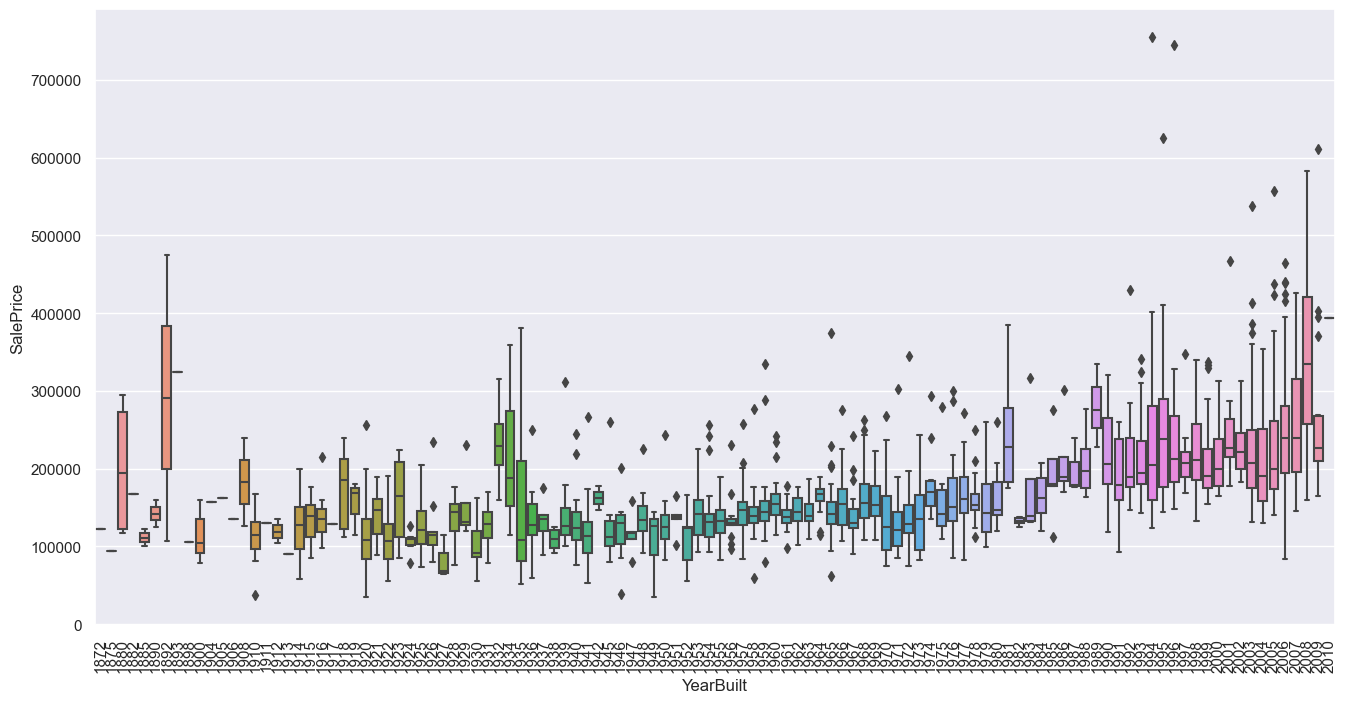

In [53]:
#box plot overallqual/saleprice
var = 'YearBuilt'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y=target, data=df)
plt.xticks(rotation=90)
plt.show()

More recent the property built the price is higher and also variance in price is also higher

#### Investigate Categorical Features

In [54]:
len(cat_features)

43

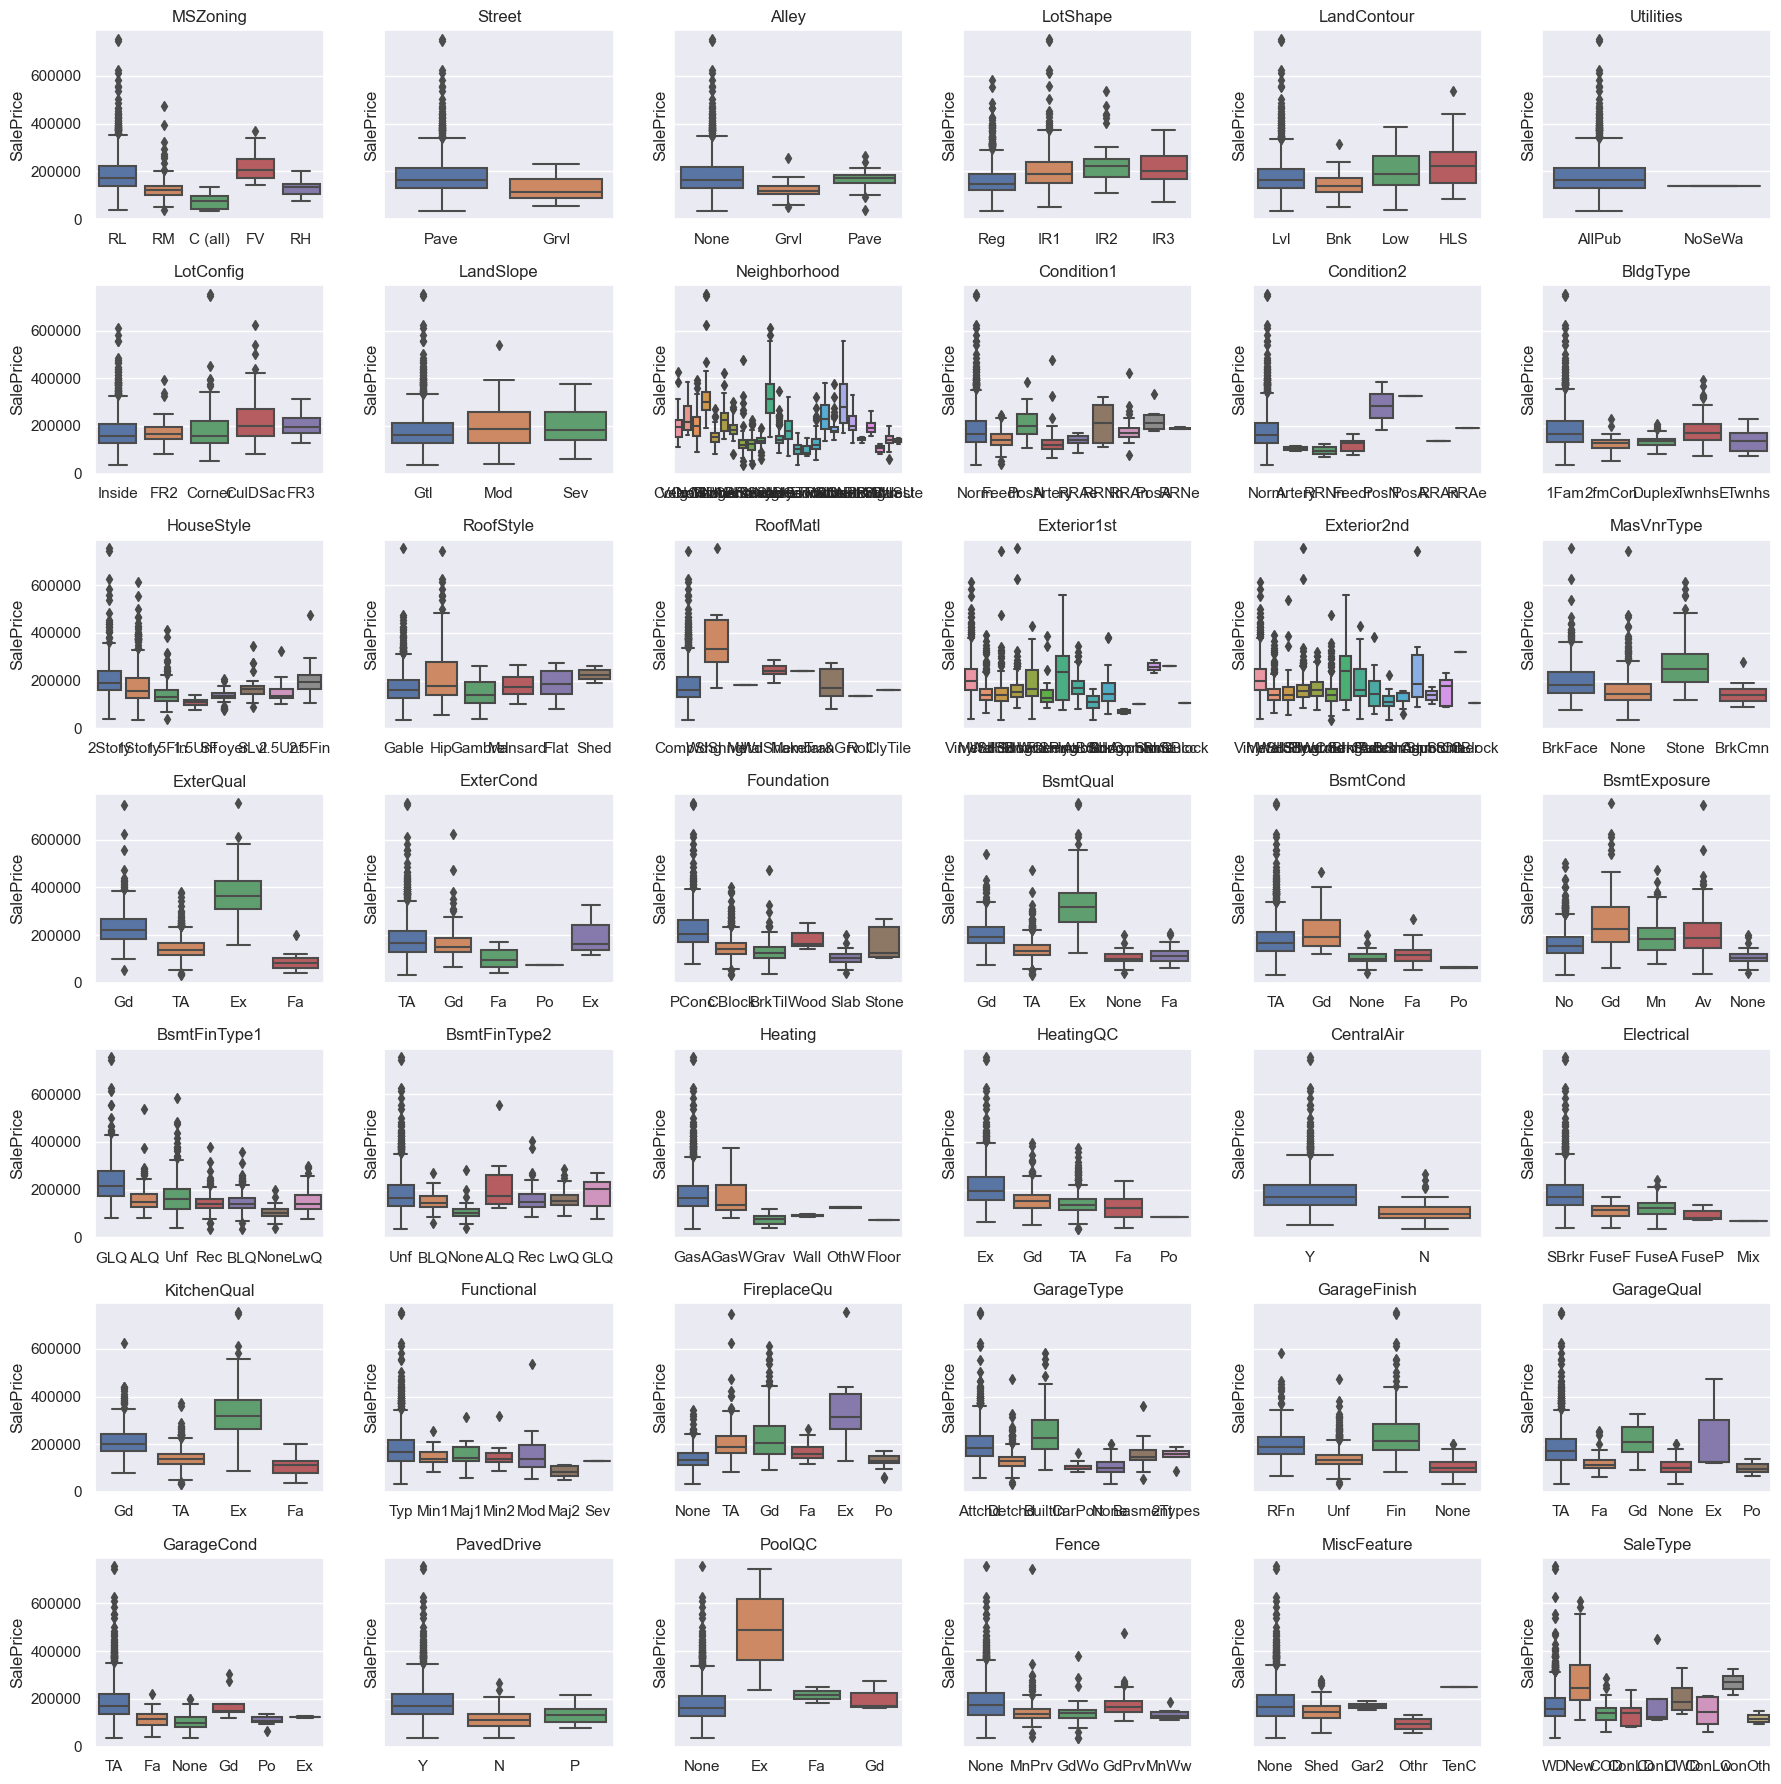

In [55]:
### Relationship between numerical features and target
fig, axes = plt.subplots(7,6, figsize = (18, 18), sharey = True)
for idx, ax in enumerate(axes.flatten()):
    if idx < len(cat_features):
        sns.boxplot(data = df, x = cat_features[idx], y = target, ax = ax)
        ax.set(title = cat_features[idx], xlabel = None)
    else:
        ax.remove()
plt.tight_layout()
plt.show()

Relationship between the categorical feautures with sale price si evident in some features suhc as Pool quality, Basement finish type 1 & 2, Heating quality, central air conditioning is present, electrical, neighborhood, lot shape, and a few others.

Ideally, it is better to use one-hot encoding on these features, but some does exists ordinal nature. Also encoding with ohe will increase the dimensionality of the dataset, and likely results in poor peformance considering realiatively low sample size.

## End